In [63]:
# imports
import torch
import torch.nn as nn  
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.interpolate import BarycentricInterpolator
import scipy
import pandas as pd
import seaborn as sns

# Marginal class

In [ ]:
class MarginalModel(nn.Module):
    def __init__(self, num_layers=5, num_neurons=5, lr=0.01):
        super(MarginalModel, self).__init__()

        # Model specification
        layers = [nn.Linear(1, num_neurons), nn.Tanh()]  # Input layer
        for _ in range(num_layers - 1):  # Hidden layers
            layers.append(nn.Linear(num_neurons, num_neurons))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(num_neurons, 1))  # Output layer
        layers.append(nn.Sigmoid())

        self.fc = nn.Sequential(*layers)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        # Data for training
        self.ObservedData = None
        self.uniform_data = torch.tensor(np.linspace(0, 1, 10000), dtype=torch.float32).view(-1, 1)
        self.lower_bound = torch.tensor([[0.0]]) 
        self.upper_bound = torch.tensor([[1.0]])

        ## For sampling
        self.domainUpper = torch.tensor([[1.0]])
        self.domainLower= torch.tensor([[0.0]])
        self.inverted = False
        self.inverseInterpolator = None

    def forward(self, x):
        return self.fc(x)

    def loss_function(self, x):
        x.requires_grad = True
        self.uniform_data.requires_grad = True
        y_pred = self(x)
        y_pred_uniform = self(self.uniform_data)
        dydx = torch.autograd.grad(y_pred, x, torch.ones_like(y_pred), create_graph=True)[0]
        dydx_uniform = torch.autograd.grad(y_pred_uniform, self.uniform_data, torch.ones_like(y_pred_uniform), create_graph=True)[0]

        L1 = -torch.mean(torch.log(torch.relu(dydx) + 1e-8))
        L2 = torch.mean(torch.relu(-dydx_uniform))
        L3 = torch.abs(1 - torch.sum(dydx_uniform)/self.uniform_data.shape[0])
        L4 = self(self.lower_bound) + torch.abs(1 - self(self.upper_bound))
        Loss = L1*0.001 + L2 + L3 +  L4
        return Loss , L1, L2, L3, L4

    def train_model(self, X, epochs=5000, log_interval=500):
        self.ObservedData = X
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            loss, L1, L2, L3, L4 = self.loss_function(X)
            loss.backward()
            self.optimizer.step()

            if epoch % log_interval == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}, Constraint losses: L1: {L1.item()}, L2: {L2.item()}, L3: {L3.item()}, L4: {L4.item()}')

    def newSamples(self, ProbabilityValues = None, n = 1000): 
        # Sampling method that replaces the interpolator which struggles with values close to 0 and 1
        if ProbabilityValues is None:
            ProbabilityValues = np.random.uniform(0, 1, n)
        if torch.is_tensor(ProbabilityValues) == False:
            ProbabilityValues = torch.tensor(ProbabilityValues, dtype=torch.float32).view(-1, 1)
        sampledData = self._vectorized_bisection(ProbabilityValues).detach().numpy()
        return sampledData

    # def sample(self, n = 1000, ProbabilityValues = None): # Can sample only from marginal and with given probability values
    #     if self.inverted == False:
    #         print("Model not inverted. Inverting model...")
    #         self.inverseInterpolator = self._invertModel(asTensor=False)
    #         self.inverted = True

    #     if ProbabilityValues is None:
    #         ProbabilityValues = np.random.uniform(0, 1, n)
            
    #     # Generate random samples from a uniform distribution
    #     sampledData = self.inverseInterpolator(ProbabilityValues)
    #     return sampledData

    # def _invertModel(self, asTensor=True, plot=False):
    #     # Invert the model to get inverse CDF function
    #     rangeUpper = self(self.domainUpper)
    #     rangeLower= self(self.domainLower)
    #     # Generate Chebyshev nodes
    #     n = 3000
    #     rangePoints = self._chebyshev_nodes(n, rangeLower, rangeUpper).view(-1, 1)

    #     # use nodes to find inverses
    #     domainPoints = self._vectorized_bisection(rangePoints)

    #     # Add boundary points
    #     rangePoints = torch.cat((torch.tensor([0.0]), rangePoints.squeeze(), torch.tensor([1.0])))
    #     domainPoints = torch.cat((torch.tensor([0.0]), domainPoints.squeeze(), torch.tensor([1.0])))
    #     rangePoints_np = rangePoints.numpy()
    #     domainPoints_np = domainPoints.numpy()

    #     # Create interpolator
    #     interpolant = BarycentricInterpolator(rangePoints_np, domainPoints_np)
    #     interpolantTensor = lambda x: self._tensor_interpolant(x, interpolant) # interpolant using PyTorch tensors

    #     if plot:
    #         self.plotModel(model = interpolantTensor)
    #     if asTensor:
    #         return interpolantTensor
    #     else:
    #         return interpolant
        
    # def _tensor_interpolant(self, p_tensor, interpolant):
    #     """Interpolant function that takes PyTorch tensors as input."""
    #     p_numpy = p_tensor.detach().cpu().numpy()
    #     x_numpy = interpolant(p_numpy)
    #     return torch.tensor(x_numpy, dtype=torch.float32)

    def PlotModel(self):
        trainingData = self.ObservedData.detach().numpy()

        # # Generate x values for plotting
        x_points = np.linspace(0, 1, 100)
        x_plot =torch.tensor(x_points, dtype=torch.float32).view(-1, 1)
        x_plot.requires_grad = True  # Enable gradients for x_plot
        y_pred = self(x_plot)  # Keep y_pred in computation graph
        pdfPred = torch.autograd.grad(y_pred, x_plot, torch.ones_like(y_pred), create_graph=True)[0]

        ### Convert to numpy for plotting
        y_vals = y_pred.detach().numpy()
        grad_vals = pdfPred.detach().numpy()

        ### Plot the neural network approximation
        plt.plot(x_points, y_vals, label='CDF approximation', linestyle='dashed')
        ### Plot the derivative
        plt.plot(x_points, grad_vals, label="PDF Approximation", linestyle='solid')
        plt.hist(trainingData, bins=1000, density=True, alpha=0.6, label='True Distribution of data');
        plt.legend()
        plt.xlabel('x')
        plt.ylabel('Density')
        plt.title('Neural Network Approximation of PDF and CDF ')
        plt.show()

    # def PlotInverse(self):
    #     if self.inverted == False:
    #         print("Model not inverted. Inverting model...")
    #         self.inverseInterpolator = self._invertModel(asTensor=False)
    #         self.inverted = True    
        
    #     x_points = np.linspace(0, 1, 1000)
    #     y_pred = self.inverseInterpolator(x_points)  
    #     #ChebyshovPoints = self._chebyshev_nodes(3000, 0, 1).numpy()
    #     plt.plot(x_points, y_pred, color='blue', label='Inverse CDF approximation')  # Blue line
    #     #plt.scatter(ChebyshovPoints, self.inverseInterpolator(ChebyshovPoints), color='red', label='Chebyshev nodes')  # Red points
    #     plt.xlabel('x')
    #     plt.ylabel('Inverse CDF')
    #     plt.title('Inverse CDF Approximation')
    #     plt.legend()
    #     plt.show()
        
    # def _chebyshev_nodes(self, n, a, b):
    #     """Generate n Chebyshev nodes in the interval [a, b]."""
    #     return torch.tensor([0.5 * (a + b) + 0.5 * (b - a) * np.cos((2 * k + 1) * np.pi / (2 * n)) for k in range(n)], dtype=torch.float32)

    def _vectorized_bisection(self, y, tol=1e-6, max_iter=100):
        """
        Vectorized Bisection Method to find roots of a function f(y) in the interval [0,1] for multiple values of y simultaneously.
        
        Parameters:
        f : function
            The function whose roots are to be found.
        y : torch.Tensor
            Tensor of values for which roots are to be found.
        tol : float, optional
            The tolerance for stopping the iteration (default is 1e-6).
        max_iter : int, optional
            Maximum number of iterations (default is 100).
        
        Returns:
        torch.Tensor
            Tensor of estimated root values.
        """
        a, b = torch.zeros_like(y), torch.ones_like(y)
        fa, fb = self(a) , self(b) 
        fa, fb = fa - y, fb - y
        
        for _ in range(max_iter):
            c = (a + b) / 2  # Midpoint
            fc = self(c) - y
            left_mask = fc * fa < 0
            right_mask = fc * fb < 0
            a, b = torch.where(left_mask, a, c), torch.where(right_mask, b, c)
            if torch.all(torch.abs(b - a) < tol):
                break
        return (a + b) / 2



# Copula Class

In [256]:
# torch.manual_seed(0)
class CopulaModel(nn.Module):
    def __init__(self, dataPoints, Marginal1, Marginal2, num_layers=5, num_neurons=5, lr=0.01):
        super(CopulaModel, self).__init__()
        dimensions = dataPoints.size(1)
        layers = [nn.Linear(dimensions, num_neurons), nn.Tanh()]  # Input layer
        for _ in range(num_layers - 1):  # Hidden layers
            layers.append(nn.Linear(num_neurons, num_neurons))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(num_neurons, 1))  # Output layer
        layers.append(nn.Sigmoid())

        self.fc = nn.Sequential(*layers)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        ### Data for training
        self.ObservedData = dataPoints
        self.Marginal1 = Marginal1
        self.Marginal2 = Marginal2
        # Boundary points
        self.upperBoundary = self._generateUpperBoundaryPoints(dimensions)
        self.lowerBoundary = self._generateLowerBoundPoints(dimensions)
        # Uniform grid points
        u= np.linspace(0.0, 1.0, 15)
        U1, U2 = np.meshgrid(u, u, indexing="ij")
        unitSquarePoints= np.column_stack((U1.ravel(), U2.ravel()))
        self.unitSquaretensor = torch.tensor(unitSquarePoints, dtype=torch.float32)

        # Look at later
        self.flagSumData = self._FlagSum(self.unitSquaretensor, self.unitSquaretensor)
        self.delta_m = 1 / dataPoints.shape[0]

        # Practicality
        self.isTrained = False


    def forward(self, x):
        return self.fc(x)

    def _CopulaGradient(self,x):
        x1 = x[:,0]
        x2 = x[:,1]
        # Probability integral transform
        ProbVals1 = self.Marginal1(x1.view(-1, 1))
        ProbVals2 = self.Marginal2(x2.view(-1, 1))
        u = torch.cat((ProbVals1, ProbVals2), dim=1)
        # Calculate marginal densities
        gradM1 = torch.autograd.grad(ProbVals1, x1, torch.ones_like(ProbVals1), create_graph=True, allow_unused=True)[0]
        gradM2 = torch.autograd.grad(ProbVals2, x2, torch.ones_like(ProbVals2), create_graph=True, allow_unused=True )[0]
        # Prediction and gradient of copula CDF
        y_pred = self(u)
        gradCopulaModel = torch.autograd.grad(y_pred, u, torch.ones_like(y_pred), create_graph=True, allow_unused=True )[0]
        CopulaGradient = gradCopulaModel[:, 0] * gradM1 * gradCopulaModel[:, 1] * gradM2
        return CopulaGradient

    def Copula_loss_function(self, x): ## MAKE SURE TO PASS IN THE SAME DATAPOINTS AS IN THE INITIALIZATION
        x.requires_grad = True
        self.unitSquaretensor.requires_grad = True
        CopulaGradientObserved = self._CopulaGradient(x)
        n_observed = x.shape[0]
        CopulaGradientUnitSquare = self._CopulaGradient(self.unitSquaretensor)
        n_unitsquare = self.unitSquaretensor.shape[0]
        flagSumData = self._FlagSum(x, self.unitSquaretensor)
        pred_unitSquare = self(self.unitSquaretensor)

        L1 = -torch.mean(torch.log(torch.relu(CopulaGradientObserved) + 1e-8))
        L2 = torch.mean(torch.relu(-CopulaGradientUnitSquare))
        L3 = torch.abs(1 - torch.sum(CopulaGradientUnitSquare / CopulaGradientUnitSquare.shape[0]))
        L4 = torch.sum(self(self.lowerBoundary)) + torch.sum(torch.abs(self(self.upperBoundary) - torch.min(self.upperBoundary, dim=1).values.view(-1,1)))      
        L5 = 1/(n_observed*n_unitsquare) * torch.sum(torch.abs(pred_unitSquare - flagSumData))

        Loss = L1 + L2 + L3 + L4 + L5
        return Loss, L1, L2, L3, L4, L5
    
    def _generateLowerBoundPoints(self, d, num_points=100):
        grid = np.linspace(0, 1, num_points)
        all_surfaces = []
        for k in range(d):
            grid_points = np.meshgrid(*([grid] * (d - 1)), indexing="ij")
            points = np.stack(grid_points, axis=-1).reshape(-1, d - 1)
            surface_points = np.insert(points, k, 0, axis=1)
            all_surfaces.append(surface_points)
        return torch.tensor(np.vstack(all_surfaces), dtype=torch.float32)

    def _generateUpperBoundaryPoints(self, d, num_points=100):
        oneArray = np.ones((d * num_points, d))
        u = np.linspace(0, 1, num_points)
        for i in range(d):
            oneArray[i * num_points:(i + 1) * num_points, i] = u
        return torch.tensor(oneArray, dtype=torch.float32)
    
    def _flag(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """Vectorized version of _flag that returns a matrix where each element is a comparison result."""
        return torch.all(y.unsqueeze(0) < x.unsqueeze(1), dim=2).float()

    def _FlagSum(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """Vectorized computation of FlagSum without explicit Python loops."""
        return self._flag(x, y).sum(dim=1)

    def train_model(self, X, epochs=5000, log_interval=500):
            for epoch in range(epochs):
                self.optimizer.zero_grad()
                loss, L1, L2, L3, L4, L5 = self.Copula_loss_function(X)
                loss.backward()
                self.optimizer.step()

                if epoch % log_interval == 0:
                    print(f'Epoch {epoch}, Loss: {loss.item()}, Losses: L1: {L1.item()}, L2: {L2.item()}, L3: {L3.item()}, L4: {L4.item()}, L5: {L5.item()}')

            self.isTrained = True


    def sample(self, n = 1000):
        if self.isTrained == False:
            print("Model not trained. Training model...")
            self.train_model(self.ObservedData)
            self.isTrained = True

        # Generate random samples from a uniform distribution
        u = np.random.uniform(0, 1, (n, 2))
        samples = np.zeros(u.shape)
        samples[:,0] = u[:,0]
        u = torch.tensor(u, dtype=torch.float32)
        u1 = u[:,0].view(-1, 1)
        ones = torch.ones_like(u1)
        uBoundary = torch.cat((u1, ones), dim=1)
        # Generate random samples from the copula
        scalings = self(uBoundary)
        z1 = u[:,1].unsqueeze(1) * scalings # Scaled random numbers on height of copula
        ## solve for u2 given u1 and z1
        u2 = self._vectorized_bisection(z1, u1_fixed = u1)
        samples[:,1] = u2.detach().numpy().flatten()
        return samples
    
    def _PartialCopula(self, u1_fixed, u2):
        u = torch.cat((u1_fixed, u2), dim=1)
        return self(u)
    
    def _vectorized_bisection(self, z, u1_fixed, tol=1e-6, max_iter=100):
        """
        Vectorized Bisection Method to find roots of a function f(z) in the interval [0,1] for multiple values of z simultaneously.
        
        Parameters:
        f : function
            The function whose roots are to be found.
        z : torch.Tensor
            Tensor of values for which roots are to be found.
        tol : float, optional
            The tolerance for stopping the iteration (default is 1e-6).
        max_iter : int, optional
            Maximum number of iterations (default is 100).
        
        Returns:
        torch.Tensor
            Tensor of estimated root values.
        """
        a, b = torch.zeros_like(z), torch.ones_like(z)
        fa, fb = self._PartialCopula(u1_fixed, a) , self._PartialCopula(u1_fixed, b) 
        fa, fb = fa - z, fb - z
        
        for _ in range(max_iter):
            c = ((a + b) / 2)  # Midpoint
            fc = self._PartialCopula(u1_fixed, c) - z
            left_mask = fc * fa < 0
            right_mask = fc * fb < 0
            a, b = torch.where(left_mask, a, c), torch.where(right_mask, b, c)
            if torch.all(torch.abs(b - a) < tol):
                break
        return (a + b) / 2
    
    def plotSamples(self, sample, ProbSpace = True):
        df_samples = pd.DataFrame({
        "U1": sample[:,0].flatten(),  
        "U2": sample[:,1].flatten()
        })
        sns.jointplot(
            data=df_samples, x="U1", y="U2", kind="scatter",
            marginal_kws=dict(bins=30, fill=True),
            joint_kws={"s": 10, "edgecolor": "none"}  # Removes white outline
        )
        if ProbSpace:
            plt.suptitle("Sampled data in probability space", y=1.02);  
        else:
            plt.suptitle("Sampled data in return space", y=1.02);
        plt.show()
        pass




# Generate Data and scale it right

In [199]:
## Creating data
corrMat = np.array([[1, 0.], [0., 1]])
A = np.linalg.cholesky(corrMat)
np.random.seed(0)
Z = np.random.standard_normal((2000, 2))
X = (A @ Z.T).T

## Normalizing data to create marginals
scaling = 2.0
Z_squashed = np.zeros((Z.shape[0]+2, Z.shape[1]))
for i in range(X.shape[1]):
    boundaryPoints = scaling * np.array([np.max(Z[:,i]), np.min(Z[:,i])]) # Creates points for bounds of what the data generated can be
    Z_added = np.concatenate((Z[:,i], boundaryPoints)) # Adding boundary points to the data
    Z_squashed[:,i] = (Z_added - np.min(Z_added)) / (np.max(Z_added) - np.min(Z_added)) # Normalizing the data

# Create tensor
X = torch.tensor(Z_squashed, dtype=torch.float32)

In [200]:
# Initialize and train the model with custom layers and neurons
Marginal1 = MarginalModel(num_layers=6, num_neurons=10, lr=0.01)
Marginal2 = MarginalModel(num_layers=6, num_neurons=10, lr=0.01)
print('Model 1 Training')
Marginal1.train_model(X[:-2,0].view(-1, 1), epochs=5000, log_interval=500)
print('Model 2 Training')
Marginal2.train_model(X[:-2,1].view(-1, 1), epochs=5000, log_interval=500)

Model 1 Training
Epoch 0, Loss: 2.0308756828308105, Constraint losses: L1: 18.42068099975586, L2: 0.004151655361056328, L3: 1.004151701927185, L4: 1.004151701927185
Epoch 500, Loss: 0.00014149222988635302, Constraint losses: L1: -1.2864042520523071, L2: 0.0, L3: 0.0007639527320861816, L4: 0.0006639438215643167
Epoch 1000, Loss: -0.0007776370039209723, Constraint losses: L1: -1.3087831735610962, L2: 0.0, L3: 0.00031560659408569336, L4: 0.00021553956321440637
Epoch 1500, Loss: -0.0009960191091522574, Constraint losses: L1: -1.3114492893218994, L2: 0.0, L3: 0.00020772218704223633, L4: 0.00010770806693471968
Epoch 2000, Loss: -0.0010842559859156609, Constraint losses: L1: -1.3118393421173096, L2: 0.0, L3: 0.00016385316848754883, L4: 6.37303019175306e-05
Epoch 2500, Loss: -0.0011290113907307386, Constraint losses: L1: -1.3118141889572144, L2: 0.0, L3: 0.00014138221740722656, L4: 4.142074612900615e-05
Epoch 3000, Loss: -0.0011552416253834963, Constraint losses: L1: -1.311789870262146, L2: 0.

## Validation plots 

Maginal model 1


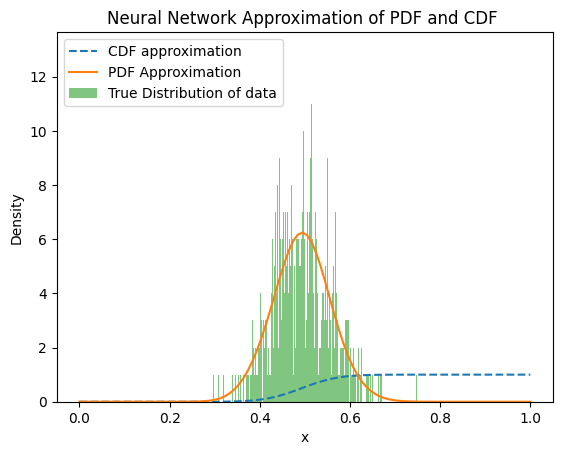

Maginal model 2


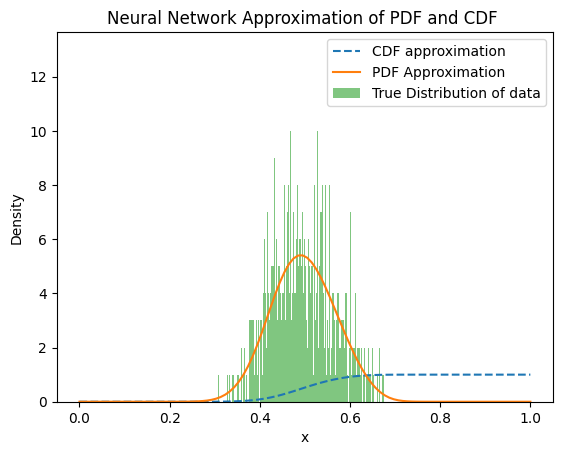

Maginal model 1
Model not inverted. Inverting model...


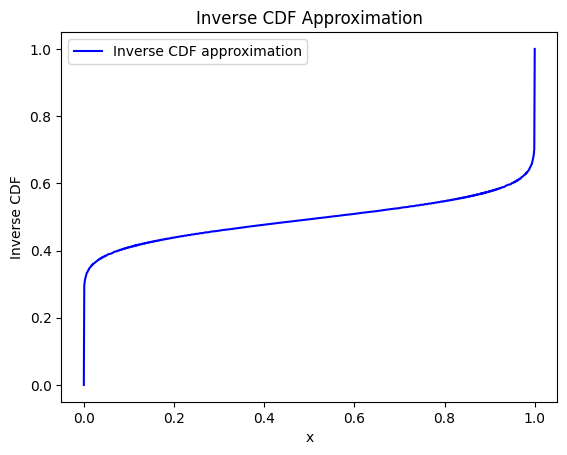

Maginal model 2
Model not inverted. Inverting model...


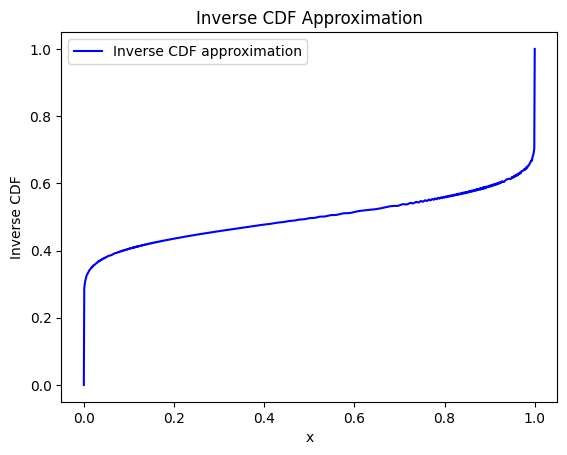

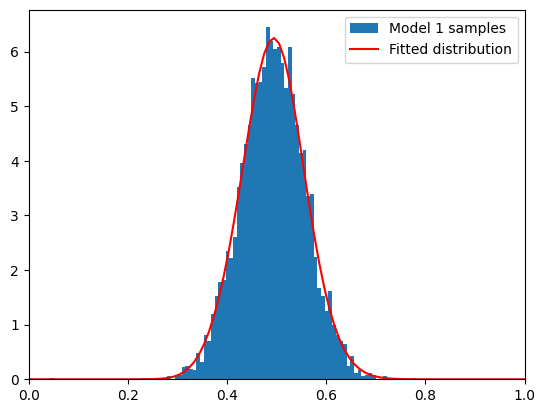

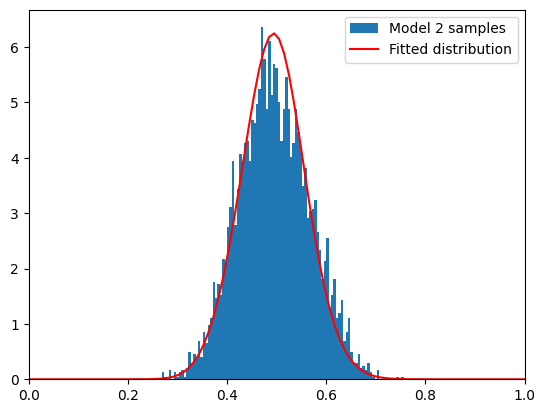

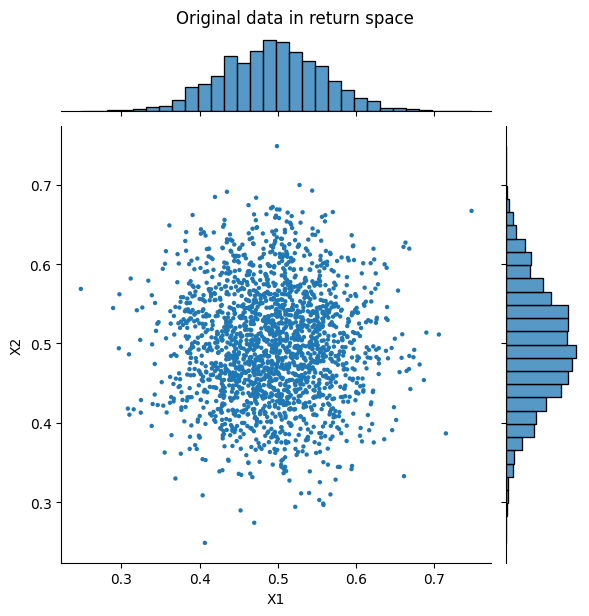

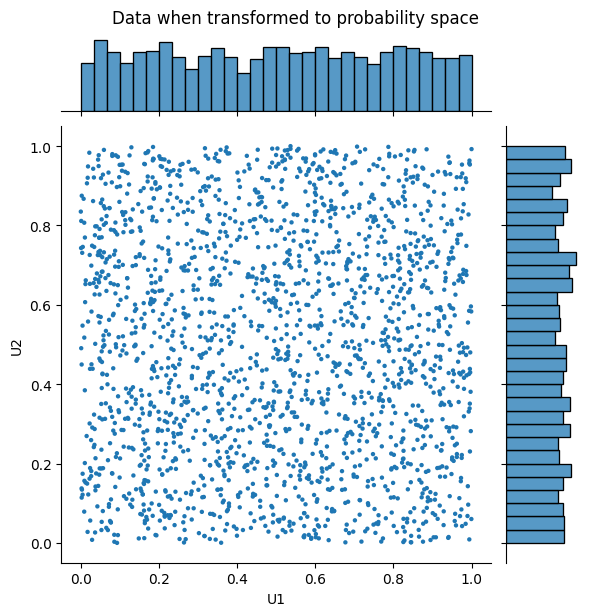

In [201]:
## Plot the marginal models
plt.fisize=(3, 3)
print('Maginal model 1')
Marginal1.PlotModel()
print('Maginal model 2')
Marginal2.PlotModel()

## Plot inverses of models to check if they are correct
print('Maginal model 1')
Marginal1.PlotInverse()
print('Maginal model 2')
Marginal2.PlotInverse()

## Plot sampled data from the models
Marginal1_samples = Marginal1.sample(5000)
Marginal2_samples = Marginal2.sample(5000)

x = np.linspace(0, 1, 100)
x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
x_tensor.requires_grad = True

y_pred1 = Marginal1(x_tensor)
dydx1 = torch.autograd.grad(y_pred1, x_tensor, torch.ones_like(y_pred1), create_graph=True)[0]
plt.hist(Marginal1_samples, bins=100, density=True, alpha=1, label='Model 1 samples')
plt.plot(x, dydx1.detach().numpy(), label='Fitted distribution', color='red')
plt.xlim(0, 1)
plt.legend()
plt.show()

y_pred2 = Marginal2(x_tensor)
dydx2 = torch.autograd.grad(y_pred2, x_tensor, torch.ones_like(y_pred2), create_graph=True)[0]
plt.hist(Marginal2_samples, bins=100, density=True, alpha=1, label='Model 2 samples')
plt.plot(x, dydx1.detach().numpy(), label='Fitted distribution', color='red')
plt.xlim(0, 1)
plt.legend()
plt.show()

## Plot initial data
OriginalMarginal1 = X[:-2,0].view(-1, 1).detach().numpy()
OriginalMarginal2 = X[:-2,1].view(-1, 1).detach().numpy()

df_returnSpace = pd.DataFrame({
    "X1": OriginalMarginal1.flatten(),  
    "X2": OriginalMarginal2.flatten()
})
sns.jointplot(
    data=df_returnSpace, x="X1", y="X2", kind="scatter",
    marginal_kws=dict(bins=30, fill=True),
    joint_kws={"s": 10, "edgecolor": "none"}  # Removes white outline
)

# Plot Transformed data
TransformedMarginal1 = Marginal1(X[:-2,0].view(-1, 1)).detach().numpy()
TransformedMarginal2 = Marginal2(X[:-2,1].view(-1, 1)).detach().numpy()

df_probabilitySpace = pd.DataFrame({
    "U1": TransformedMarginal1.flatten(),  # Flatten in case of (N,1) shape
    "U2": TransformedMarginal2.flatten()
})
plt.suptitle("Original data in return space", y=1.02);

# Plot the jointplot
sns.jointplot(
    data=df_probabilitySpace, x="U1", y="U2", kind="scatter",
    marginal_kws=dict(bins=30, fill=True),
    joint_kws={"s": 10, "edgecolor": "none"}  # Removes white outline
)
plt.suptitle("Data when transformed to probability space", y=1.02);

## Copula training

In [202]:
# Initialize and train the copula model
torch.manual_seed(0)
print('Training copula model')
copula = CopulaModel(X[:-2], Marginal1, Marginal2)
copula.train_model(X[:-2], epochs=5000, log_interval=500)
sample = copula.sample()


Training copula model
Epoch 0, Loss: 199.33419799804688, Losses: L1: 14.60035514831543, L2: 7.757833958565996e-11, L3: 0.9999999403953552, L4: 183.4886474609375, L5: 0.24519068002700806
Epoch 500, Loss: 5.537953853607178, Losses: L1: 1.824002742767334, L2: 0.0, L3: 0.6279424428939819, L4: 2.840817928314209, L5: 0.24519068002700806
Epoch 1000, Loss: 5.513457298278809, Losses: L1: 1.5655384063720703, L2: 0.0, L3: 0.6162668466567993, L4: 3.086461305618286, L5: 0.24519068002700806
Epoch 1500, Loss: 5.124542236328125, Losses: L1: 1.65018892288208, L2: 0.0, L3: 0.619053065776825, L4: 2.610109329223633, L5: 0.24519068002700806
Epoch 2000, Loss: 8.326506614685059, Losses: L1: 1.2459566593170166, L2: 0.0, L3: 0.5117617845535278, L4: 6.3235979080200195, L5: 0.24519068002700806
Epoch 2500, Loss: 5.484156131744385, Losses: L1: 1.3054794073104858, L2: 0.0, L3: 0.5875469446182251, L4: 3.3459391593933105, L5: 0.24519068002700806
Epoch 3000, Loss: 2.8802027702331543, Losses: L1: -0.18241378664970398, 

## Visualization of copula

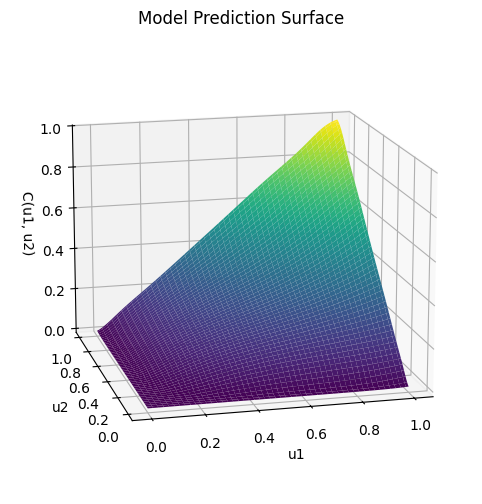

In [203]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create meshgrid
u1 = np.linspace(0, 1, 100)
u2 = np.linspace(0, 1, 100)
U1, U2 = np.meshgrid(u1, u2, indexing="ij")
grid = np.column_stack((U1.ravel(), U2.ravel()))
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# Get model predictions
copula.eval()
with torch.no_grad():
    predictions = copula(grid_tensor)
Z = predictions.numpy().reshape(100, 100)  

# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(U1, U2, Z, cmap="viridis")
ax.set_xlabel("u1")
ax.set_ylabel("u2")
ax.set_zlabel("C(u1, u2)")
ax.set_title("Model Prediction Surface")
ax.view_init(elev=15, azim=256)
plt.show()


## Validation of being 2-increasing

In [204]:
resultCol = Z[:, 1:] >= Z[:, :-1]
resultRow = Z[1:, :] >= Z[:-1, :]

has_false_col = np.any(resultCol == False)
has_false_row = np.any(resultRow == False)

print("Any False in resultCol?", has_false_col)
print("Any False in resultRow?", has_false_row)

Any False in resultCol? True
Any False in resultRow? False


In [205]:
# Find indexes where the result is False
falseColIdx = np.where(resultCol == False)  # Indices in column-wise comparison
falseRowIdx = np.where(resultRow == False)  # Indices in row-wise comparison

# Adjust indices for full matrix (since resultCol and resultRow have reduced dimensions)
falseColIdx = (falseColIdx[0], falseColIdx[1] + 1)  # Shift column indices to match original Z
falseRowIdx = (falseRowIdx[0] + 1, falseRowIdx[1])  # Shift row indices to match original Z

# Combine results if needed
falseIdx = list(zip(*falseColIdx)) + list(zip(*falseRowIdx))

print("Indices where False in column-wise comparison:", list(zip(*falseColIdx)))
print("Indices where False in row-wise comparison:", list(zip(*falseRowIdx)))
print("All False indices:", falseIdx)

Indices where False in column-wise comparison: [(np.int64(0), np.int64(47)), (np.int64(0), np.int64(48)), (np.int64(0), np.int64(49)), (np.int64(0), np.int64(50)), (np.int64(0), np.int64(51)), (np.int64(0), np.int64(52)), (np.int64(0), np.int64(53)), (np.int64(0), np.int64(54)), (np.int64(0), np.int64(55)), (np.int64(0), np.int64(56)), (np.int64(0), np.int64(57)), (np.int64(0), np.int64(58)), (np.int64(0), np.int64(59)), (np.int64(0), np.int64(60)), (np.int64(0), np.int64(61)), (np.int64(0), np.int64(62))]
Indices where False in row-wise comparison: []
All False indices: [(np.int64(0), np.int64(47)), (np.int64(0), np.int64(48)), (np.int64(0), np.int64(49)), (np.int64(0), np.int64(50)), (np.int64(0), np.int64(51)), (np.int64(0), np.int64(52)), (np.int64(0), np.int64(53)), (np.int64(0), np.int64(54)), (np.int64(0), np.int64(55)), (np.int64(0), np.int64(56)), (np.int64(0), np.int64(57)), (np.int64(0), np.int64(58)), (np.int64(0), np.int64(59)), (np.int64(0), np.int64(60)), (np.int64(0), n

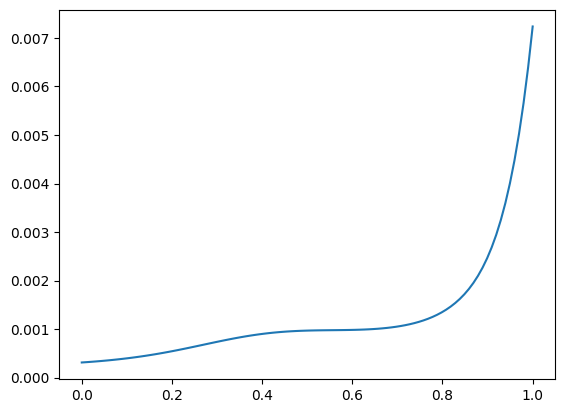

In [208]:
def evaluate_model(model, fixed_value=0.75, num_points=100, varying_index=0):
    """
    Evaluates the model by varying one variable from 0 to 1 while keeping the other fixed.
    :param model: Trained CopulaModel
    :param fixed_value: Fixed value for the non-varying variable
    :param num_points: Number of evaluation points
    :param varying_index: Index of the variable that varies (0 or 1)
    :return: Evaluation results as a numpy array
    """
    
    # Generate values for the varying variable
    varying_values = np.linspace(0, 1, num_points)
    
    # Prepare input tensor
    inputs = np.full((num_points, 2), fixed_value)
    inputs[:, varying_index] = varying_values
    
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    
    # Evaluate model
    with torch.no_grad():
        outputs = model(inputs_tensor).numpy()
    
    return varying_values, outputs

# Evaluate model with first variable varying and second fixed 
x_values, y_outputs = evaluate_model(copula, fixed_value=0.001, num_points=100, varying_index=0)
plt.plot(x_values, y_outputs)

## Sample from Copula

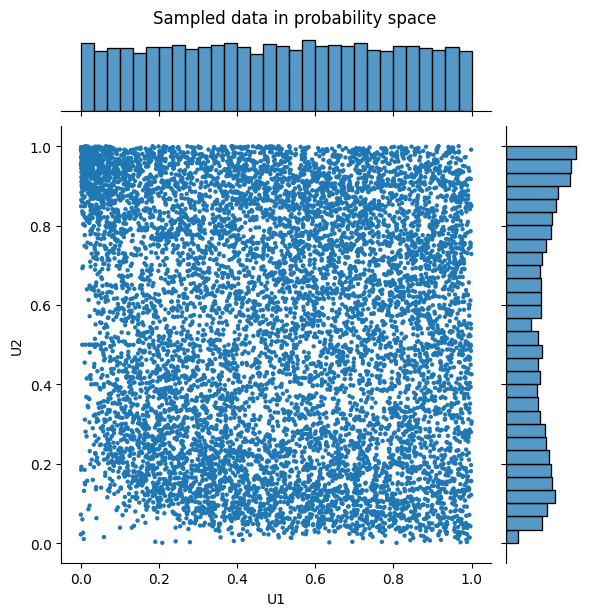

In [209]:
sample = copula.sample(n=10000)

df_samples = pd.DataFrame({
    "U1": sample[:,0].flatten(),  
    "U2": sample[:,1].flatten()
})
sns.jointplot(
    data=df_samples, x="U1", y="U2", kind="scatter",
    marginal_kws=dict(bins=30, fill=True),
    joint_kws={"s": 10, "edgecolor": "none"}  # Removes white outline
)
plt.suptitle("Sampled data in probability space", y=1.02);

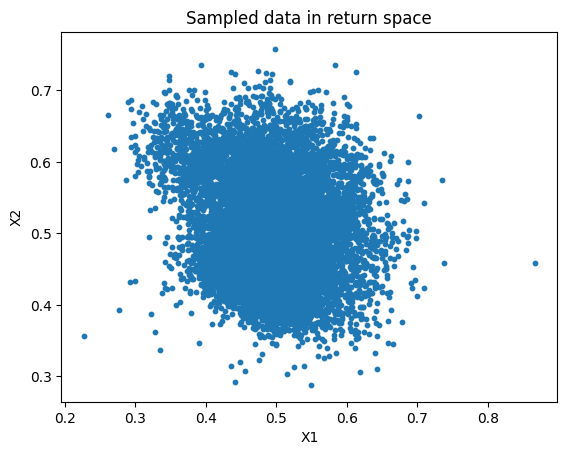

In [ ]:
marginal1Samples = Marginal1.sample(ProbabilityValues=sample[:,0])
marginal2Samples = Marginal2.sample(ProbabilityValues=sample[:,1])


plt.scatter(marginal1Samples[np.where(marginal1Samples<1)], marginal2Samples[np.where(marginal1Samples<1)], s=10)
plt.title("Sampled data in return space")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()



# idx = np.where(marginal1Samples > 1)
# a = 0.9999993688244624
# Marginal1.inverseInterpolator(1.0)



# Combined Neural Copula Class

In [257]:
class NeuralCopula():
    def __init__(self, data, num_layers=5, num_neurons=5, lr=0.01):
        self.Marginal1 = None
        self.Marginal2 = None
        self.Copula = None
        self.data = data
        self.normalizedData = None
        self.normalizedDataAsTensor = None
        self.isNormalized = False

        ## Normalization variables
        self.scaling = 2.0
        self.M1_upper = None
        self.M1_lower = None
        self.M2_upper = None
        self.M2_lower = None

    def normalizeData(self,scaling=2.0):
        scaling = 2.0
        n = self.data.shape[0]
        d = self.data.shape[1]

        self.M1_upper = scaling * np.max(self.data[:,0])
        self.M1_lower = scaling * np.min(self.data[:,0])
        self.M2_upper = scaling * np.max(self.data[:,1])
        self.M2_lower = scaling * np.min(self.data[:,1])

        M1boundaryPoints =  np.array([self.M1_upper, self.M1_lower]) # Creates points for bounds of what the data generated can be
        M2boundaryPoints =  np.array([self.M2_upper, self.M2_lower]) # Creates points for bounds of what the data generated can be
        extendedData = np.zeros((n+2, d))
        extendedData[:,0] = np.concatenate((self.data[:,0], M1boundaryPoints)) # Adding boundary points to the data
        extendedData[:,1] = np.concatenate((self.data[:,1], M2boundaryPoints))
        self.normalizedData= (extendedData - np.min(extendedData,axis=0)) / (np.max(extendedData,axis=0) - np.min(extendedData,axis=0))
        self.normalizedDataAsTensor = torch.tensor(self.normalizedData, dtype=torch.float32)
        self.isNormalized = True
        pass

    def denormalizeData(self,NormalizedData):
        DeNormalizedData = NormalizedData * (np.max(self.data, axis=0) - np.min(self.data, axis=0)) + np.min(self.data, axis=0)
        return DeNormalizedData

    def fitModel(self):
        ## Training marginals
        self.Marginal1 = MarginalModel(num_layers=6, num_neurons=10, lr=0.01)
        self.Marginal2 = MarginalModel(num_layers=6, num_neurons=10, lr=0.01)
        print('Model 1 Training')
        self.Marginal1.train_model(self.normalizedDataAsTensor[:-2,0].view(-1, 1), epochs=5000, log_interval=500)
        print('Model 2 Training')
        self.Marginal2.train_model(self.normalizedDataAsTensor[:-2,1].view(-1, 1), epochs=5000, log_interval=500)
        ## Training copula
        self.Copula = CopulaModel(self.normalizedDataAsTensor[:-2], self.Marginal1, self.Marginal2) 
        print('Training copula model')
        self.Copula.train_model(self.normalizedDataAsTensor[:-2], epochs=5000, log_interval=500)
        print('Training done')
        pass

    def sample(self, Plot = False, n=1000):
        copulaSample = self.Copula.sample(n)
        marginalSamples = self.sample_marginals(copulaSample)
        denormalizedSamples = self.denormalizeData(marginalSamples)
        if Plot:
            self.Copula.plotSamples(copulaSample, ProbSpace = True)
            self.Copula.plotSamples(denormalizedSamples, ProbSpace = False)

        return denormalizedSamples

    def sample_marginals(self,probabilityValues, n=1000):
        sample_marginal1 = self.Marginal1.newSamples(ProbabilityValues=probabilityValues[:,0])
        sample_marginal2 = self.Marginal2.newSamples(ProbabilityValues=probabilityValues[:,1])
        samples = np.column_stack((sample_marginal1, sample_marginal2))
        return samples

    def sample_copula(self, Plot = False, n = 1000):
        copulaSample = self.Copula.sample(n)
        if Plot:
            self.Copula.plotSamples(copulaSample, ProbSpace = True)
        return copulaSample
    

In [ ]:
## Creating data
torch.manual_seed(0)
np.random.seed(0)
corrMat = np.array([[1, 0.], [0., 1]])
A = np.linalg.cholesky(corrMat)
Z = np.random.standard_normal((2000, 2))
X = (A @ Z.T).T

NC = NeuralCopula(X)
NC.normalizeData()
NC.fitModel()


Model 1 Training
Epoch 0, Loss: 2.0180776119232178, Constraint losses: L1: 17.79229164123535, L2: 0.0001217599055962637, L3: 1.0000817775726318, L4: 1.0000817775726318
Epoch 500, Loss: -0.0001075398176908493, Constraint losses: L1: -1.2666475772857666, L2: 0.0, L3: 0.0006294846534729004, L4: 0.0005296231247484684
Epoch 1000, Loss: -0.000880268809851259, Constraint losses: L1: -1.3068766593933105, L2: 0.0, L3: 0.0002632737159729004, L4: 0.00016333424719050527
Epoch 1500, Loss: -0.0010509103303775191, Constraint losses: L1: -1.3110780715942383, L2: 0.0, L3: 0.00018006563186645508, L4: 8.010216697584838e-05
Epoch 2000, Loss: -0.00111726438626647, Constraint losses: L1: -1.3117631673812866, L2: 0.0, L3: 0.00014728307723999023, L4: 4.721576988231391e-05
Epoch 2500, Loss: -0.0011505826842039824, Constraint losses: L1: -1.311738133430481, L2: 0.0, L3: 0.00013059377670288086, L4: 3.056173591176048e-05
Epoch 3000, Loss: -0.0011697408044710755, Constraint losses: L1: -1.3117018938064575, L2: 0.0

shape (10000, 1)
max 0.77337503
min 0.77337503
shape (10000, 1)
max 0.76086426
min 0.76086426


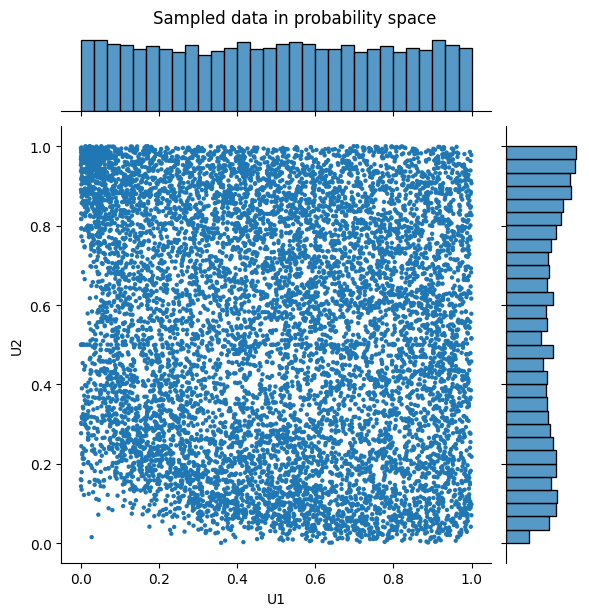

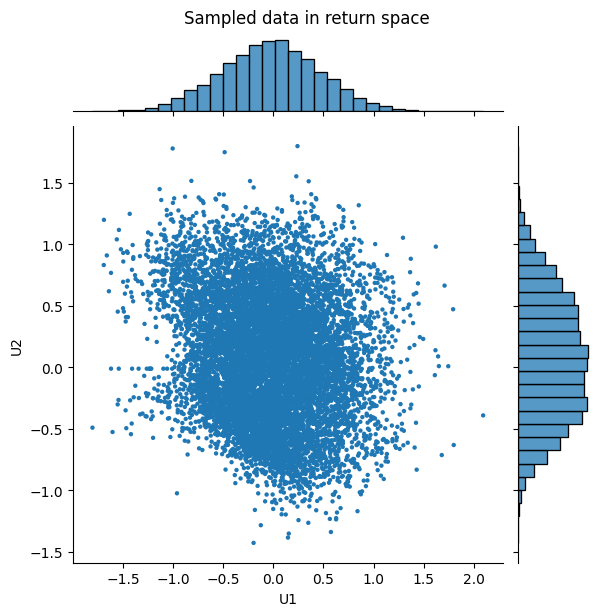

In [259]:
returnSpaceSamples = NC.sample(n=10000,Plot = True)

In [270]:
class NC_validator():
    def __init__(self, NeuralCopula):
        self.NC = NeuralCopula
        self.Marginal1 = NeuralCopula.Marginal1
        self.Marginal2 = NeuralCopula.Marginal2
        self.Copula = NeuralCopula.Copula
        self.normalizedDataASTensor = NeuralCopula.normalizedDataAsTensor
        

    def validate(self):
        print('Marginal model validation')
        self._validateMarginals()
        print('Copula model validation')
        self._validateCopula()
        pass

    def _validateMarginals(self): 
        ## Plot the marginal models
        plt.fisize=(3, 3)
        print('Maginal model 1')
        self.Marginal1.PlotModel()
        print('Maginal model 2')
        self.Marginal2.PlotModel()

        # ## Plot inverses of models to check if they are correct
        # print('Maginal model 1')
        # self.Marginal1.PlotInverse()
        # print('Maginal model 2')
        # self.Marginal2.PlotInverse()

        ## Plot sampled data from the models
        Marginal1_samples = self.Marginal1.newSamples(n = 5000)
        Marginal2_samples = self.Marginal2.newSamples(n = 5000)

        x = np.linspace(0, 1, 100)
        x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
        x_tensor.requires_grad = True

        y_pred1 = Marginal1(x_tensor)
        dydx1 = torch.autograd.grad(y_pred1, x_tensor, torch.ones_like(y_pred1), create_graph=True)[0]
        plt.hist(Marginal1_samples, bins=100, density=True, alpha=1, label='Model 1 samples')
        plt.plot(x, dydx1.detach().numpy(), label='Fitted distribution', color='red')
        plt.xlim(0, 1)
        plt.legend()
        plt.show()

        y_pred2 = Marginal2(x_tensor)
        dydx2 = torch.autograd.grad(y_pred2, x_tensor, torch.ones_like(y_pred2), create_graph=True)[0]
        plt.hist(Marginal2_samples, bins=100, density=True, alpha=1, label='Model 2 samples')
        plt.plot(x, dydx2.detach().numpy(), label='Fitted distribution', color='red')
        plt.xlim(0, 1)
        plt.legend()
        plt.show()

        ## Plot initial data
        OriginalMarginal1 = self.normalizedDataASTensor[:-2,0].view(-1, 1).detach().numpy()
        OriginalMarginal2 = self.normalizedDataASTensor[:-2,1].view(-1, 1).detach().numpy()

        df_returnSpace = pd.DataFrame({
            "X1": OriginalMarginal1.flatten(),  
            "X2": OriginalMarginal2.flatten()
        })
        sns.jointplot(
            data=df_returnSpace, x="X1", y="X2", kind="scatter",
            marginal_kws=dict(bins=30, fill=True),
            joint_kws={"s": 10, "edgecolor": "none"}  # Removes white outline
        )

        # Plot Transformed data
        TransformedMarginal1 = Marginal1(self.normalizedDataASTensor[:-2,0].view(-1, 1)).detach().numpy()
        TransformedMarginal2 = Marginal2(self.normalizedDataASTensor[:-2,1].view(-1, 1)).detach().numpy()

        df_probabilitySpace = pd.DataFrame({
            "U1": TransformedMarginal1.flatten(),  # Flatten in case of (N,1) shape
            "U2": TransformedMarginal2.flatten()
        })
        plt.suptitle("Original data in return space", y=1.02);

        # Plot the jointplot
        sns.jointplot(
            data=df_probabilitySpace, x="U1", y="U2", kind="scatter",
            marginal_kws=dict(bins=30, fill=True),
            joint_kws={"s": 10, "edgecolor": "none"}  # Removes white outline
        )
        plt.suptitle("Data when transformed to probability space", y=1.02);
        pass


    def _validateCopula(self):
        # Create meshgrid
        u1 = np.linspace(0, 1, 100)
        u2 = np.linspace(0, 1, 100)
        U1, U2 = np.meshgrid(u1, u2, indexing="ij")
        grid = np.column_stack((U1.ravel(), U2.ravel()))
        grid_tensor = torch.tensor(grid, dtype=torch.float32)

        # Get model predictions
        self.Copula.eval()
        with torch.no_grad():
            predictions = self.Copula(grid_tensor)
        Z = predictions.numpy().reshape(100, 100)  

        # Plot
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(U1, U2, Z, cmap="viridis")
        ax.set_xlabel("u1")
        ax.set_ylabel("u2")
        ax.set_zlabel("C(u1, u2)")
        ax.set_title("Fitted Model Surface")
        ax.view_init(elev=15, azim=256)
        plt.show()

        print('Is the model 2-increasing?')
        resultCol = Z[:, 1:] >= Z[:, :-1]
        resultRow = Z[1:, :] >= Z[:-1, :]
        has_false_col = np.any(resultCol == False)
        has_false_row = np.any(resultRow == False)
        print("Any False in resultCol?", has_false_col)
        print("Any False in resultRow?", has_false_row)

        if has_false_col or has_false_row:
            print("Model is not 2-increasing")
            # Find indexes where the result is False
            falseColIdx = np.where(resultCol == False)  # Indices in column-wise comparison
            falseRowIdx = np.where(resultRow == False)  # Indices in row-wise comparison

            # Adjust indices for full matrix (since resultCol and resultRow have reduced dimensions)
            falseColIdx = (falseColIdx[0], falseColIdx[1] + 1)  # Shift column indices to match original Z
            falseRowIdx = (falseRowIdx[0] + 1, falseRowIdx[1])  # Shift row indices to match original Z

            # Combine results if needed
            falseIdx = list(zip(*falseColIdx)) + list(zip(*falseRowIdx))

            print("Indices where False in column-wise comparison:", list(zip(*falseColIdx)))
            print("Indices where False in row-wise comparison:", list(zip(*falseRowIdx)))
            print("All False indices:", falseIdx)
        pass



Marginal model validation
Maginal model 1


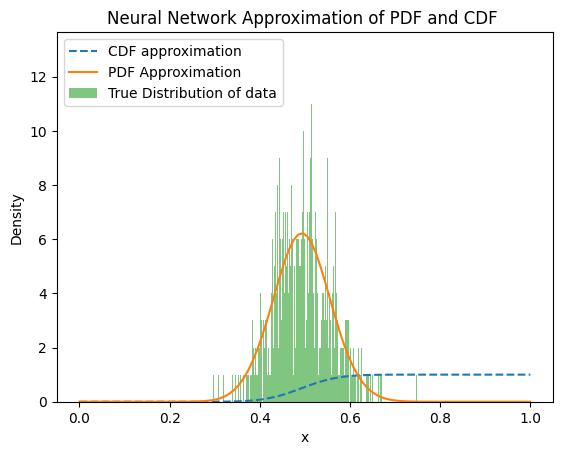

Maginal model 2


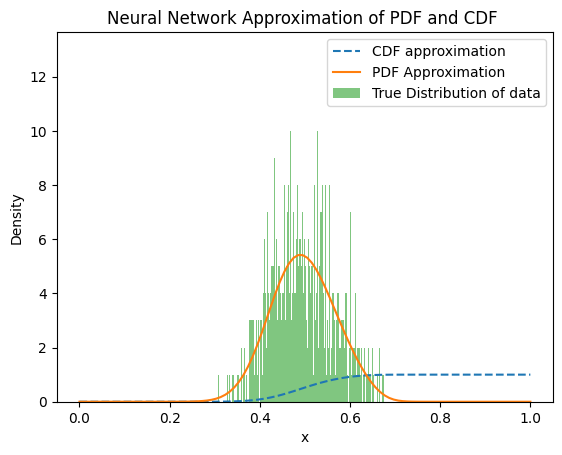

shape (5000, 1)
max 0.72663116
min 0.72663116
shape (5000, 1)
max 0.7188058
min 0.7188058


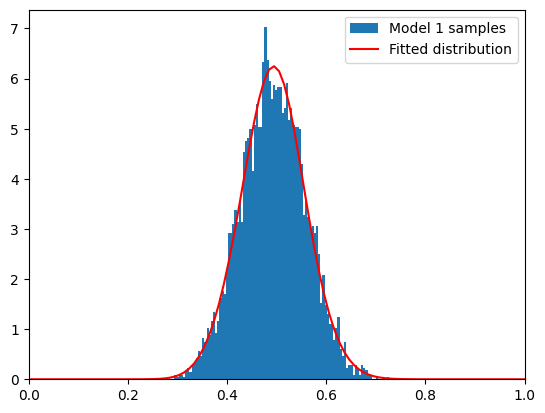

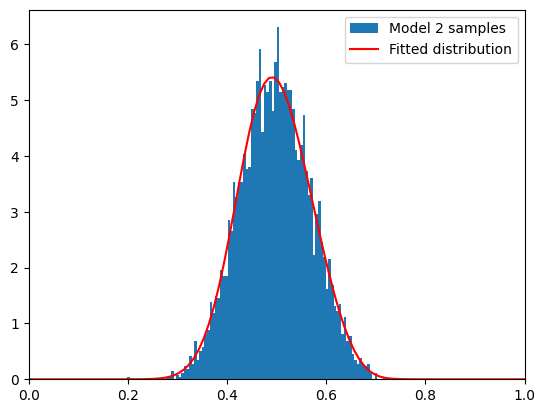

Copula model validation


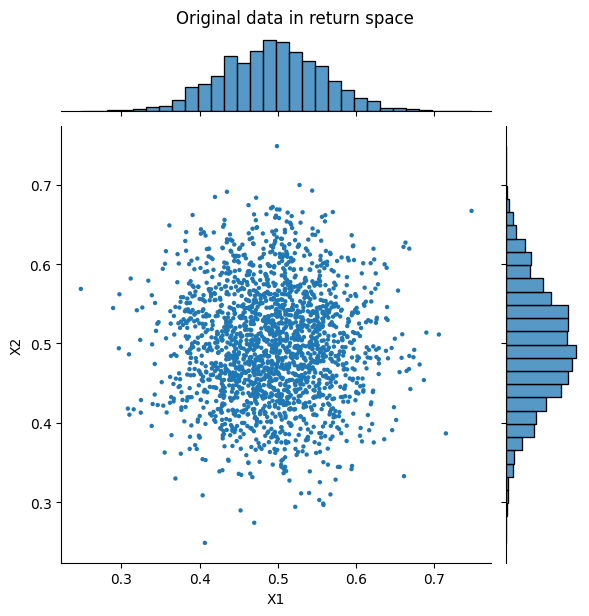

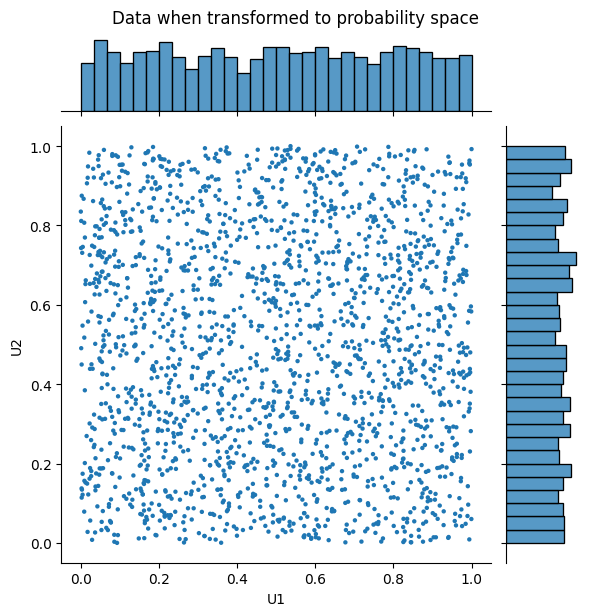

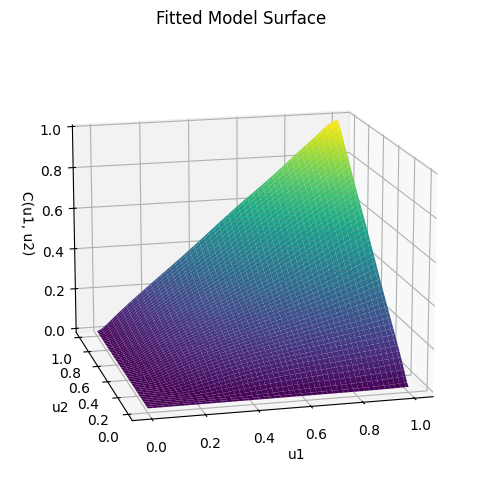

Is the model 2-increasing?
Any False in resultCol? True
Any False in resultRow? False
Model is not 2-increasing
Indices where False in column-wise comparison: [(np.int64(0), np.int64(53)), (np.int64(0), np.int64(54)), (np.int64(0), np.int64(55)), (np.int64(0), np.int64(56)), (np.int64(0), np.int64(57)), (np.int64(0), np.int64(58)), (np.int64(0), np.int64(59)), (np.int64(0), np.int64(60)), (np.int64(0), np.int64(61)), (np.int64(0), np.int64(62)), (np.int64(0), np.int64(63)), (np.int64(0), np.int64(64)), (np.int64(0), np.int64(65))]
Indices where False in row-wise comparison: []
All False indices: [(np.int64(0), np.int64(53)), (np.int64(0), np.int64(54)), (np.int64(0), np.int64(55)), (np.int64(0), np.int64(56)), (np.int64(0), np.int64(57)), (np.int64(0), np.int64(58)), (np.int64(0), np.int64(59)), (np.int64(0), np.int64(60)), (np.int64(0), np.int64(61)), (np.int64(0), np.int64(62)), (np.int64(0), np.int64(63)), (np.int64(0), np.int64(64)), (np.int64(0), np.int64(65))]


In [271]:
validator = NC_validator(NC)
validator.validate()